# Network Anomaly Detection

In [166]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import pickle

## Exploratory Data Analysis

In [95]:
#Load the dataset
df = pd.read_csv(r"D:\DSML_class\Real world data assignments\DSML Project\Network_anomaly_data.csv")

### Basic understanding of the data

In [147]:
df.head(5)

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsrvrerrorrate,attack,lastflag,duration_flag,log_srcbytes,log_dstbytes,byte_ratio,total_bytes,bytes_per_sec,label
0,0,tcp,ftp_data,SF,491.0,0.0,0,0,0,0,...,0.0,normal,20,0,6.198479,0.000000,491.000000,491.0,491.0,normal
1,0,udp,other,SF,146.0,0.0,0,0,0,0,...,0.0,normal,15,0,4.990433,0.000000,146.000000,146.0,146.0,normal
2,0,tcp,private,S0,0.0,0.0,0,0,0,0,...,0.0,neptune,19,0,0.000000,0.000000,0.000000,0.0,0.0,attack
3,0,tcp,http,SF,232.0,1290.0,0,0,0,0,...,0.0,normal,21,0,5.451038,7.163172,0.179706,1522.0,1522.0,normal
4,0,tcp,http,SF,199.0,420.0,0,0,0,0,...,0.0,normal,21,0,5.298317,6.042633,0.472684,619.0,619.0,normal


In [6]:
df.shape

(125973, 43)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   duration                125973 non-null  int64  
 1   protocoltype            125973 non-null  object 
 2   service                 125973 non-null  object 
 3   flag                    125973 non-null  object 
 4   srcbytes                125973 non-null  int64  
 5   dstbytes                125973 non-null  int64  
 6   land                    125973 non-null  int64  
 7   wrongfragment           125973 non-null  int64  
 8   urgent                  125973 non-null  int64  
 9   hot                     125973 non-null  int64  
 10  numfailedlogins         125973 non-null  int64  
 11  loggedin                125973 non-null  int64  
 12  numcompromised          125973 non-null  int64  
 13  rootshell               125973 non-null  int64  
 14  suattempted         

In [8]:
df.describe(include='all')

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
count,125973.00000,125973,125973,125973,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973,125973.000000
unique,NaN,3,70,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN
top,NaN,tcp,http,SF,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,NaN
freq,NaN,102689,40338,74945,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67343,NaN
mean,287.14465,NaN,NaN,NaN,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,...,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,NaN,19.504060
std,2604.51531,NaN,NaN,NaN,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,...,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,NaN,2.291503
min,0.00000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,0.00000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,18.000000
50%,0.00000,NaN,NaN,NaN,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,20.000000
75%,0.00000,NaN,NaN,NaN,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,NaN,21.000000


In [9]:
#Check for null values or missing values if any
print('\nTotal number of missing values: ', df.isna().sum().sum())


Total number of missing values:  0


In [10]:
df.columns

Index(['duration', 'protocoltype', 'service', 'flag', 'srcbytes', 'dstbytes',
       'land', 'wrongfragment', 'urgent', 'hot', 'numfailedlogins', 'loggedin',
       'numcompromised', 'rootshell', 'suattempted', 'numroot',
       'numfilecreations', 'numshells', 'numaccessfiles', 'numoutboundcmds',
       'ishostlogin', 'isguestlogin', 'count', 'srvcount', 'serrorrate',
       'srvserrorrate', 'rerrorrate', 'srvrerrorrate', 'samesrvrate',
       'diffsrvrate', 'srvdiffhostrate', 'dsthostcount', 'dsthostsrvcount',
       'dsthostsamesrvrate', 'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate',
       'dsthostrerrorrate', 'dsthostsrvrerrorrate', 'attack', 'lastflag'],
      dtype='object')

In [97]:
#Define categorical and numerical columns
cat_columns = df.select_dtypes(include='object')
num_columns = df.select_dtypes(include='number')

#### Checking for duplicates

In [4]:
print('\nTotal number of duplicated rows =', df.duplicated().sum())


Total number of duplicated rows = 0


### Distribution of the target variable

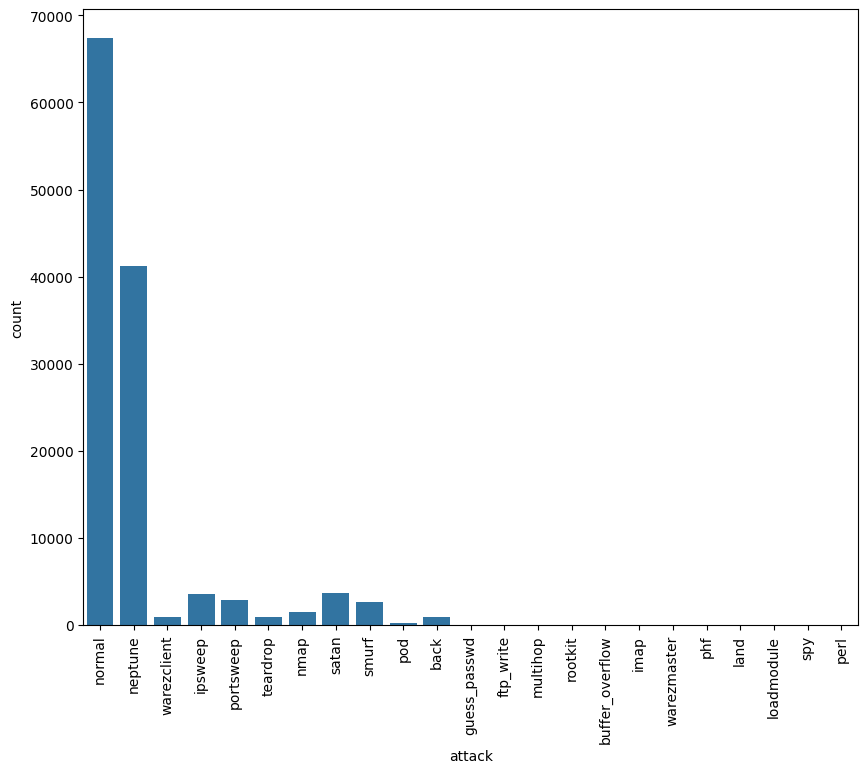

In [5]:
plt.figure(figsize=(10,8))
sns.countplot(data=df, x='attack')
plt.xticks(rotation=90)
plt.show()

#### Insights

1. Normal traffic (67,343) is the most frequent category, which is good—it suggests most activity is benign.
2. The most common attack is Neptune (41,214), a DoS (Denial of Service) attack targeting TCP.
3. The top 5 most common attack types are neptune, satan, ipsweep, portsweep, smurf. These attacks could represent automated scanning or flooding attempts, which are often precursors to larger breaches.
4. These have very low counts but could indicate serious security threats:
   - buffer_overflow (30), rootkit (10), loadmodule (9), and perl (3) suggest exploitation attempts to gain unauthorized access or execute arbitrary code.
   - spy (2) and phf (4) are also rare and could represent stealthy or legacy threats.



### Univariate Analysis

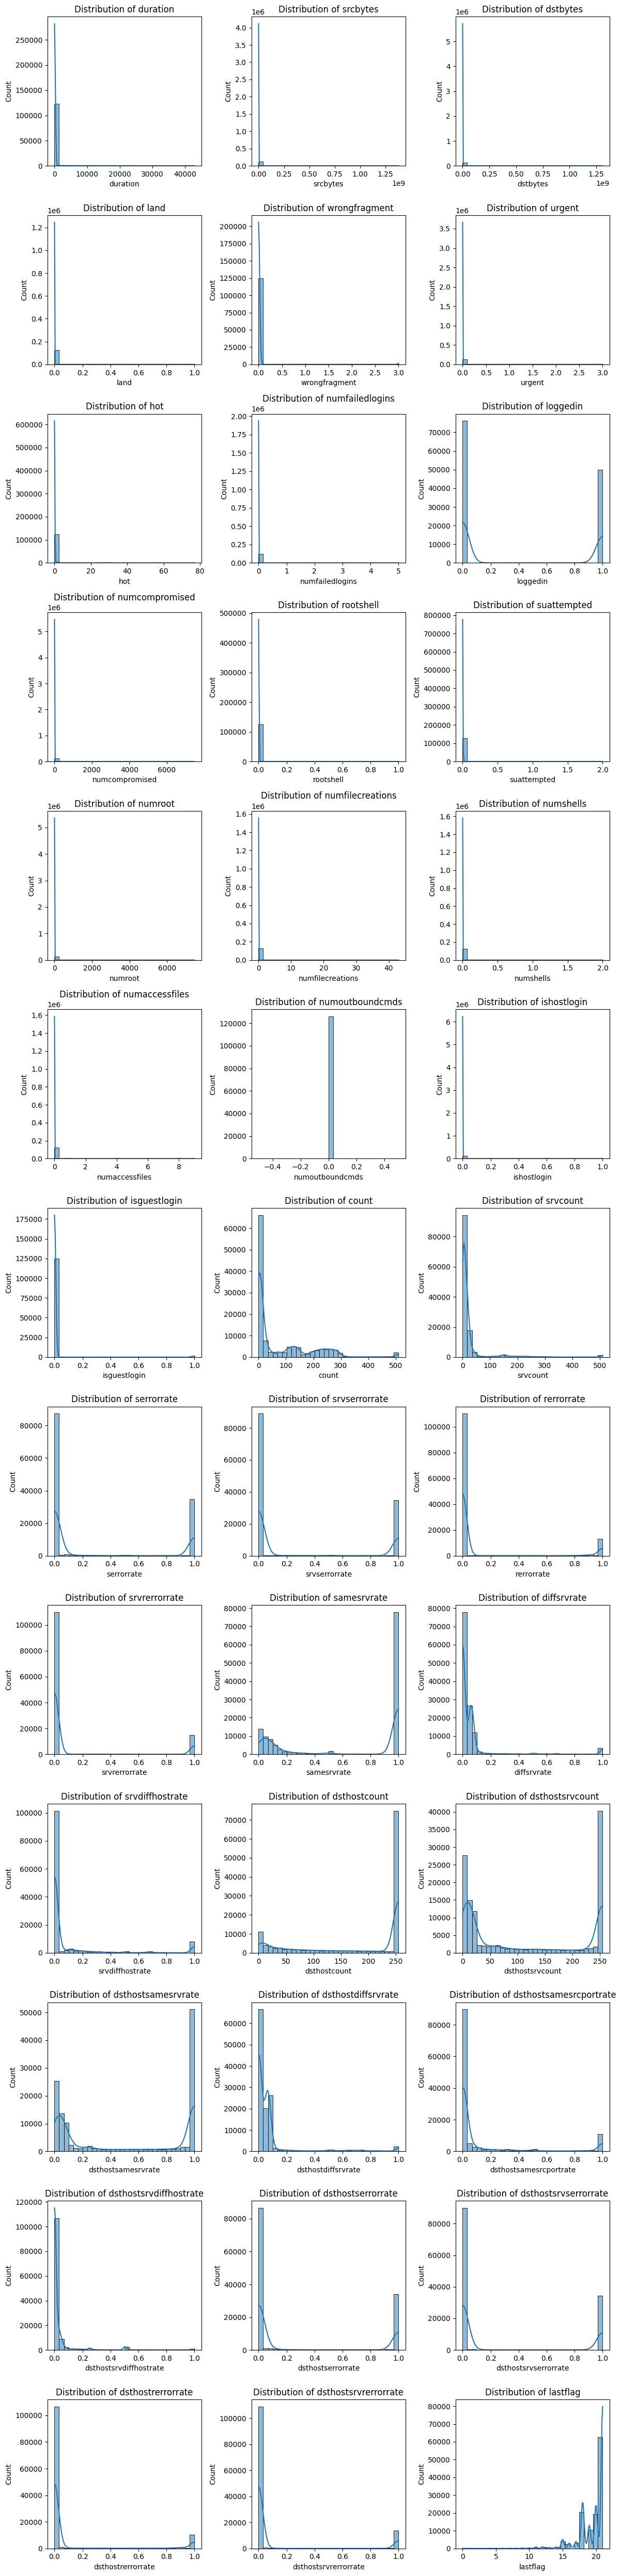

In [14]:
# Checking the distribution of numerical columns
plt.figure(figsize=(12,50))
for i, column in enumerate(num_columns.columns, 1):
    plt.subplot(13,3,i)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

### Correlation Analysis

In [15]:
corr_mat = df.corr(numeric_only=True)

<Axes: >

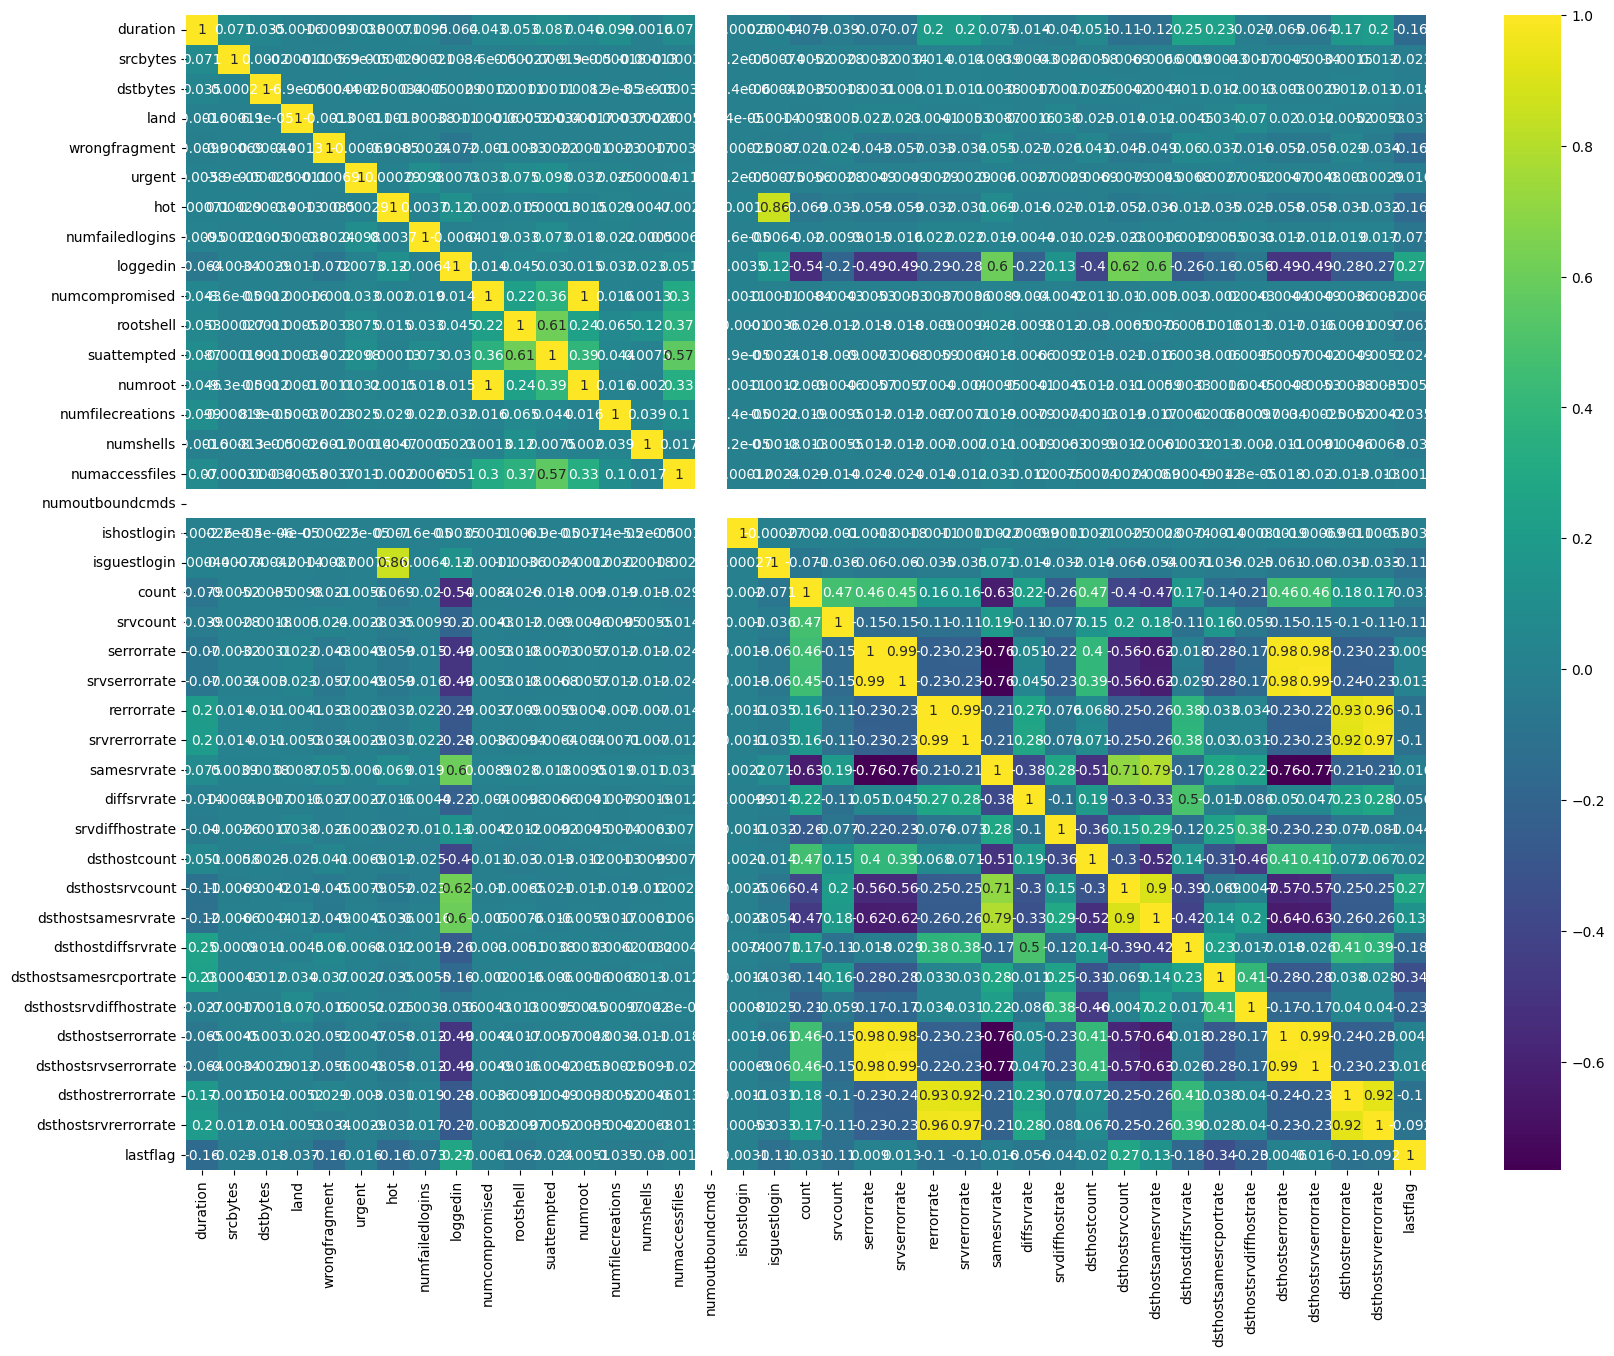

In [16]:
plt.figure(figsize=(20,15))
sns.heatmap(corr_mat, cmap='viridis', annot=True)

### Outlier Detection

In [98]:
#Finding the number of unique values in the numerical columns
num_columns.nunique()

duration                  2981
srcbytes                  3341
dstbytes                  9326
land                         2
wrongfragment                3
urgent                       4
hot                         28
numfailedlogins              6
loggedin                     2
numcompromised              88
rootshell                    2
suattempted                  3
numroot                     82
numfilecreations            35
numshells                    3
numaccessfiles              10
numoutboundcmds              1
ishostlogin                  2
isguestlogin                 2
count                      512
srvcount                   509
serrorrate                  89
srvserrorrate               86
rerrorrate                  82
srvrerrorrate               62
samesrvrate                101
diffsrvrate                 95
srvdiffhostrate             60
dsthostcount               256
dsthostsrvcount            256
dsthostsamesrvrate         101
dsthostdiffsrvrate         101
dsthosts

#### Insights:
1. Columns with more than 20 unique values are generally considered continuous. However, some categorical variables like hot also exceed this count (with 28 unique values). To account for such cases, we set a more conservative threshold of 30 unique values to distinguish continuous features for outlier detection.

2. Features like duration, srcbytes, and dstbytes have the highest number of unique values, indicating they are highly variable and potentially impactful. If these contain outliers, they could significantly influence the model’s performance and must be treated carefully.

In [99]:
#Checking the values in duration column
df['duration'].value_counts()

duration
0        115955
1          1989
2           843
3           557
4           351
          ...  
13488         1
41254         1
3047          1
1327          1
679           1
Name: count, Length: 2981, dtype: int64

In [100]:
zero_value = round((df['duration']==0).sum()/df.shape[0]*100,2)
print(f'Percentage of zero values in duration column: {zero_value}')

Percentage of zero values in duration column: 92.05


Since the majority of values (92%) in the duration column are zero, applying traditional outlier treatment (like IQR-based clipping) would incorrectly classify most non-zero values as outliers and potentially reduce them to zero. Therefore, it's more appropriate to exclude this column from outlier treatment to preserve meaningful variation in the small proportion of non-zero values.

In [101]:
target_cols = [col for col in num_columns.columns if df[col].nunique()>30]

In [102]:
for col in target_cols:
    if col == 'duration':
        pass
    else:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
    
        outliers = ((df[col]<lower) | (df[col]>upper)).sum()
        print(f'{col}: ', outliers)
    
        #Treating the outliers
        df[col] = np.where(df[col]<lower, lower, df[col])
        df[col] = np.where(df[col]>upper, upper, df[col])
    

srcbytes:  13840
dstbytes:  23579
numcompromised:  1286
numroot:  649
numfilecreations:  287
count:  3157
srvcount:  12054
serrorrate:  0
srvserrorrate:  0
rerrorrate:  16190
srvrerrorrate:  16206
samesrvrate:  0
diffsrvrate:  7788
srvdiffhostrate:  28399
dsthostcount:  0
dsthostsrvcount:  0
dsthostsamesrvrate:  0
dsthostdiffsrvrate:  10550
dsthostsamesrcportrate:  25052
dsthostsrvdiffhostrate:  11682
dsthostserrorrate:  0
dsthostsrvserrorrate:  0
dsthostrerrorrate:  22795
dsthostsrvrerrorrate:  19357


In [103]:
#Checking for outliers after treatment
for col in target_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = ((df[col]<lower) | (df[col]>upper)).sum()
    print(f'{col}: ', outliers)

duration:  10018
srcbytes:  0
dstbytes:  0
numcompromised:  0
numroot:  0
numfilecreations:  0
count:  0
srvcount:  0
serrorrate:  0
srvserrorrate:  0
rerrorrate:  0
srvrerrorrate:  0
samesrvrate:  0
diffsrvrate:  0
srvdiffhostrate:  0
dsthostcount:  0
dsthostsrvcount:  0
dsthostsamesrvrate:  0
dsthostdiffsrvrate:  0
dsthostsamesrcportrate:  0
dsthostsrvdiffhostrate:  0
dsthostserrorrate:  0
dsthostsrvserrorrate:  0
dsthostrerrorrate:  0
dsthostsrvrerrorrate:  0


### Feature Engineering

##### Duration Flag

In [104]:
#Creating a binary feature from duration
df['duration_flag'] = np.where(df['duration'] == 0, 0, 1)

The newly created duration_flag feature is likely to be more informative than the raw duration column, as it effectively captures the presence or absence of activity in a connection, an important distinction given that the majority of values are zero.

##### Log Transform Skewed Features

In [105]:
df['log_srcbytes'] = np.log1p(df['srcbytes'])
df['log_dstbytes'] = np.log1p(df['dstbytes'])

In [106]:
#Deriving features that capture relative information between src and dst

##### Byte Ratio

In [107]:
df['byte_ratio'] = df['srcbytes'] / (df['dstbytes'] + 1)

##### Byte Sum

In [108]:
df['total_bytes'] = df['srcbytes'] + df['dstbytes']

##### Bytes per second

In [109]:
df['bytes_per_sec'] = df['total_bytes'] / (df['duration'] + 1)

##### Label from Attack 

In [110]:
df['label'] = df['attack'].apply(lambda x: x if x=='normal' else 'attack')

### Hypothesis Testing

#### 1. Network Traffic Volume and Anomalies

- H₀ (Null Hypothesis): There is no significant difference in mean src_bytes and dst_bytes between normal and anomalous connections.
- H₁ (Alternative Hypothesis): The mean src_bytes and/or dst_bytes differs significantly between normal and anomalous connections.

In [30]:
#split normal and attack labels
normal = df[df['attack']=='normal']
anomaly = df[df['attack']!='normal']

In [31]:
t_src = ttest_ind(normal['srcbytes'], anomaly['srcbytes'], equal_var=False)
t_dst = ttest_ind(normal['dstbytes'], anomaly['dstbytes'], equal_var=False)

In [32]:
if t_src.pvalue<0.05:
    print('Reject Null hypothesis, which means the mean srcbytes differs significantly between normal and anamalous connections')
else:
    print('There is no significant difference in mean src_bytes between normal and anomalous connections.')

Reject Null hypothesis, which means the mean srcbytes differs significantly between normal and anamalous connections


In [33]:
def check_pvalue(res, feature):
    if res.pvalue<0.05:
        print(f'Reject Null hypothesis, which means the mean {feature}bytes differs significantly between normal and anamalous connections.')
    else:
        print(f'There is no significant difference in mean {feature}bytes between normal and anomalous connections.')
    

In [34]:
print('\nT-test results')
check_pvalue(t_dst, 'dst')
check_pvalue(t_src, 'src')


T-test results
Reject Null hypothesis, which means the mean dstbytes differs significantly between normal and anamalous connections.
Reject Null hypothesis, which means the mean srcbytes differs significantly between normal and anamalous connections.


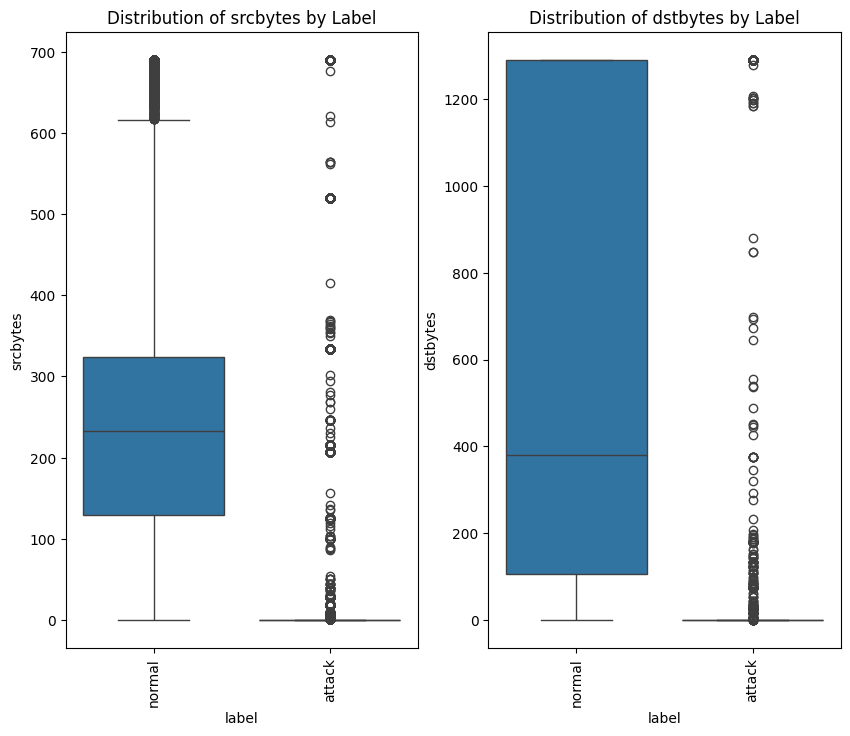

In [35]:
#Visualising 
plt.figure(figsize=(10,8))
for i, col in enumerate (['srcbytes', 'dstbytes'],1):
    plt.subplot(1,2,i)
    sns.boxplot(data=df, x='label', y=col)
    plt.xticks(rotation=90)
    plt.title(f'Distribution of {col} by Label')
plt.show()

#### Insights
The distributions of both srcbytes and dstbytes vary significantly between normal and attack connections:

- Normal traffic shows a wider spread and higher medians in both srcbytes and dstbytes, indicating more active data exchange between source and destination.

- Attack traffic, in contrast, exhibits low median values close to zero for both features, with a large concentration of records transmitting minimal or no data.

- Despite this, numerous outliers are present in attack traffic for both features, suggesting some attacks involve unusually high byte transfers.

- Both features are right-skewed, with extreme values affecting the scale, making them good candidates for log transformation.

#### 2. Impact of Protocol Type on Anomaly Detection

- Null Hypothesis (H₀): protocoltype and label are independent — protocol usage is the same in normal and anomalous traffic.
- Alternative Hypothesis (H₁): protocoltype and label are not independent — certain protocols are more associated with attacks.

In [36]:
#Create a contingency table
contingency_table = pd.crosstab(df['protocoltype'], df['label'])
print(contingency_table)

label         attack  normal
protocoltype                
icmp            6982    1309
tcp            49089   53600
udp             2559   12434


In [37]:
#Perfroming Chi-square test
chi2_prt = chi2_contingency(contingency_table)
print(f'\nThe pvalue of the chi2 contingency test is {chi2_prt.pvalue}')


The pvalue of the chi2 contingency test is 0.0


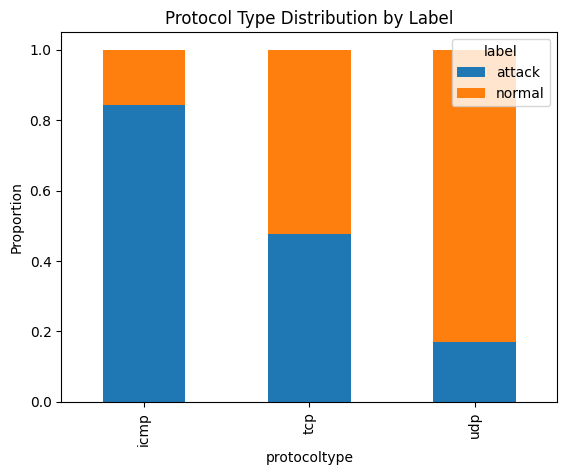

In [38]:
#Visualising the results 
contingency_table_norm = contingency_table.div(contingency_table.sum(1), axis=0)
contingency_table_norm.plot(kind='bar', stacked=True)
plt.title("Protocol Type Distribution by Label")
plt.ylabel("Proportion")
plt.show()

#### Insights:
1. The p-value = 0, which indicates strong evidence against the null hypothesis and statistically significant association between the protocol type and whether a network connection is normal or anomalous.
2. ICMP Traffic is Highly Anomalous

- 84.2% of ICMP connections are labeled as attacks, indicating that this protocol is heavily associated with anomalous or malicious behavior. This suggests ICMP is a strong signal for identifying suspicious activity.

3. UDP Traffic is Mostly Normal

- 82.9% of UDP traffic is labeled as normal, making it the most benign among the three protocols. This could imply that anomalies using UDP are relatively rare in this dataset.

4. TCP Traffic is Balanced

- TCP traffic shows a more even distribution, with 52.2% normal and 47.8% attack. This suggests TCP-based attacks are common but not dominant, and additional features should be used alongside protocol to detect anomalies.



#### 3. Role of Service in Network Security

- Null Hypothesis (H₀): Service usage is independent of whether a connection is normal or an attack.
- Alternative Hypothesis (H₁): Some services are more likely associated with attacks.

In [39]:
#Create a contingency table
contingency_table = pd.crosstab(df['service'], df['label'])

In [40]:
#performing Chi-square test
chi2_service = chi2_contingency(contingency_table)
print(f'\nThe pvalue of the chi2 contingency test is {chi2_service.pvalue}')


The pvalue of the chi2 contingency test is 0.0


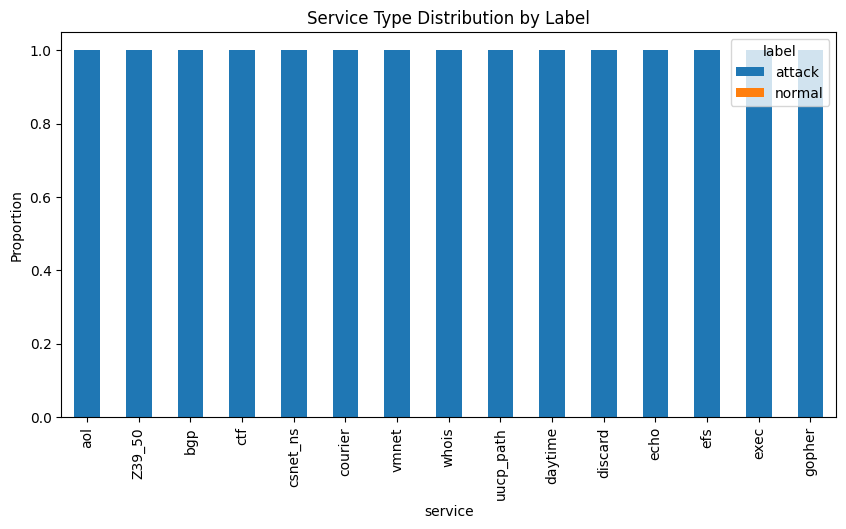

In [41]:
#Visualising the results 
contingency_table_norm = contingency_table.div(contingency_table.sum(1), axis=0)
top_services = contingency_table_norm.sort_values('attack', ascending=False).head(15)
top_services.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title("Service Type Distribution by Label")
plt.ylabel("Proportion")
plt.show()

#### Insights:
1. The chi-square test revealed a statistically significant relationship (p-value = 0) between service and label, indicating that certain services are more likely to be associated with anomalous connections. These services could represent vulnerable entry points and should be closely monitored in real-time intrusion detection systems.
2. The above 15 services show exclusive association with attack traffic — none of their connections are normal.
3. This pattern strongly suggests these services are either highly vulnerable or commonly exploited in attack scenarios.

#### 4. Connection Status and Anomalies

- Null Hypothesis (H₀): There is no significant association between the error flags in the Flag feature (connection status) and the occurrence of anomalies.
- Alternate Hypothesis (H₁): There is a significant association between the error flags in the Flag feature and the occurrence of anomalies.

In [42]:
#Binary encoding the target variable and storing as y for Logistic regression
y = df['label'].apply(lambda x: 1 if x=='attack' else 0)

#One hot encoding the flag and storing it in X
X = pd.get_dummies(df['flag'], prefix='flag', drop_first=True).astype(float)


#Creating the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Using the statsmodel to get the p-values for interpretation
X_sm = sm.add_constant(X_train)
model = sm.Logit(y_train, X_sm)
result = model.fit(maxiter=100, method='bfgs')

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.330369
         Iterations: 99
         Function evaluations: 100
         Gradient evaluations: 100
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                88181
Model:                          Logit   Df Residuals:                    88170
Method:                           MLE   Df Model:                           10
Date:                Fri, 16 May 2025   Pseudo R-squ.:                  0.5216
Time:                        07:09:34   Log-Likelihood:                -29132.
converged:                       True   LL-Null:                       -60894.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0086      0.377 

#### Insights
1. The model has a Pseudo R-squared of 0.5216, indicating a strong explanatory power (52% of the variance in anomaly occurrence is explained).
2. The model is statistically significant (LLR p-value < 0.001) and hence rejecting the null hypothesis and there is statistical evidence that the connection status flags are significantly associated with anomalies.
3. Flags like RSTOS0, RSTR, S0, and SH are strong predictors of anomalies.
4. Flags S1, S2, S3, and SF appear to be associated with normal or non-anomalous behavior.

#### 5. Influence of Urgent Packets

- Null Hypothesis (H₀): There is no significant association between the urgent packets and the occurrence of anomalies.
- Alternate Hypothesis (H₁): There is a significant association between the urgent packets and the occurrence of anomalies.

In [43]:
#Binary encoding the target variable and storing as y for Logistic regression
y = df['label'].apply(lambda x: 1 if x=='attack' else 0)
X = df['urgent'].astype(float)


#Creating the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Using the statsmodel to get the p-values for interpretation
X_sm = sm.add_constant(X_train)
model = sm.Logit(y_train, X_sm)
result = model.fit(maxiter=100)

print(result.summary())

         Current function value: 0.690526
         Iterations: 100
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                88181
Model:                          Logit   Df Residuals:                    88179
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 May 2025   Pseudo R-squ.:               5.122e-05
Time:                        07:09:35   Log-Likelihood:                -60891.
converged:                      False   LL-Null:                       -60894.
Covariance Type:            nonrobust   LLR p-value:                   0.01251
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1439      0.007    -21.312      0.000      -0.157      -0.131
urgent       -15.8778   1739.811     -0.009      0.993   -3425.8

C:\Users\shaje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Insights:
1. The pvalue of the urgent is 0.993 which is close to 1 and doesn't have any statistical significance and hence failed to reject the null hypothesis.
2. Coefficient is unstable, model hasn’t converged.
3. Indicates urgent field is not a good predictor of anomalies in your dataset.

### Model Building

#### Preparing the dataset for modelling

In [111]:
#Creating a copy of the dataset to work with for modeling
df_copy = df.copy()

In [112]:
df_copy.head(5)

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsrvrerrorrate,attack,lastflag,duration_flag,log_srcbytes,log_dstbytes,byte_ratio,total_bytes,bytes_per_sec,label
0,0,tcp,ftp_data,SF,491.0,0.0,0,0,0,0,...,0.0,normal,20,0,6.198479,0.000000,491.000000,491.0,491.0,normal
1,0,udp,other,SF,146.0,0.0,0,0,0,0,...,0.0,normal,15,0,4.990433,0.000000,146.000000,146.0,146.0,normal
2,0,tcp,private,S0,0.0,0.0,0,0,0,0,...,0.0,neptune,19,0,0.000000,0.000000,0.000000,0.0,0.0,attack
3,0,tcp,http,SF,232.0,1290.0,0,0,0,0,...,0.0,normal,21,0,5.451038,7.163172,0.179706,1522.0,1522.0,normal
4,0,tcp,http,SF,199.0,420.0,0,0,0,0,...,0.0,normal,21,0,5.298317,6.042633,0.472684,619.0,619.0,normal


In [113]:
# Dropping the duration, srcbytes and dstbytes columns to avoid multicollinearity 
df_copy.drop(['duration', 'srcbytes', 'dstbytes'], axis=1, inplace=True)

In [114]:
#Dropping the attack column as label is derived from attack with binary classification
df_copy.drop('attack', axis=1, inplace=True)

In [115]:
#Creating the target variable
y = df['label'].apply(lambda x: 1 if x=='attack' else 0)

#Dropping the label to create X
df_copy.drop('label', axis=1, inplace=True)

In [116]:
#Dropping the urgent column as it has no relevence with the target variable
df_copy.drop('urgent', axis=1, inplace=True)

#### Encoding the categorical variables

In [117]:
#Checking for categorical columns
df_copy.select_dtypes(include='object').head(5)

,protocoltype,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [118]:
#Checking the number of unique values
print(df['protocoltype'].nunique())
print(df['service'].nunique())
print(df['flag'].nunique())

3
70
11


- Protocol type and flag have less unique values and hence one-hot encoding.
- Service has high unique values, and to avoid high dimensionality, target encoding is used.

In [119]:
#One hot encoding for protocoltype and flag
df_encoded = pd.get_dummies(df_copy, columns=['protocoltype', 'flag'], drop_first=True)

In [120]:
#Train test split before target encoding to avoid data leakage
X = df_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [121]:
#Target encoding the service feature
te = TargetEncoder()
X_train['service'] = te.fit_transform(X_train['service'], y_train)
X_test['service'] = te.transform(X_test['service'])

#### Scaling the dataset

In [122]:
#Initialise the scaler
scaler = StandardScaler()

#Scaling the dataset
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [46]:
#Finding the best parameters using grid search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [ 8.8, 8.9, 9, 9.1, 9.2],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(lr, cv=5, param_grid=param_grid, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'C': 9, 'penalty': 'l2', 'solver': 'liblinear'}


### Logistic Regression Model

In [123]:
#Initialize the model
lr = LogisticRegression(random_state=42, max_iter=1000, C=9, penalty='l2', solver='liblinear')

#Fit the model on the training data
lr.fit(X_train_scaled, y_train)

LogisticRegression(C=9, max_iter=1000, random_state=42, solver='liblinear')

In [124]:
#Making the predictions
lr_y_train_pred = lr.predict(X_train_scaled)
lr_y_test_pred = lr.predict(X_test_scaled)

#### Evaluating the model

In [125]:
lr_train_score = accuracy_score(y_train, lr_y_train_pred)
lr_test_score = accuracy_score(y_test, lr_y_test_pred)

print(f"Training Accuracy: {lr_train_score:.4f}")
print(f"Testing Accuracy: {lr_test_score:.4f}")

Training Accuracy: 0.9926
Testing Accuracy: 0.9920


#### Confusion matrix

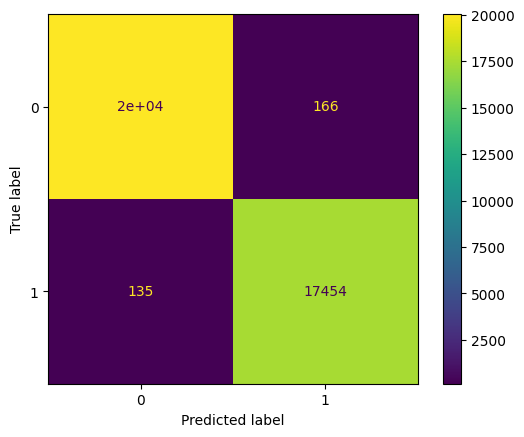

In [127]:
conf_matrix = confusion_matrix(y_test, lr_y_test_pred)

ConfusionMatrixDisplay(conf_matrix).plot()

#### Classification Report

In [128]:
class_report = classification_report(y_test, lr_y_test_pred)
print(f"Classification Report:\n{class_report}")

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20203
           1       0.99      0.99      0.99     17589

    accuracy                           0.99     37792
   macro avg       0.99      0.99      0.99     37792
weighted avg       0.99      0.99      0.99     37792



#### ROC-AUC Curve

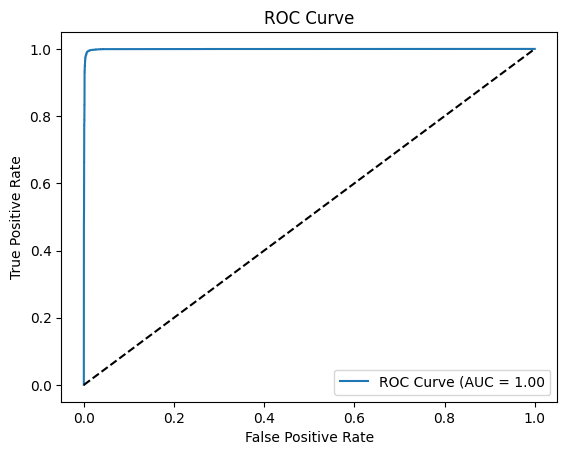

In [129]:
lr_y_test_prob = lr.predict_proba(X_test_scaled)[:, 1]

#Compute ROC AUC Score
roc_auc = roc_auc_score(y_test, lr_y_test_prob)

#Plot the ROC Curve
fpr, tpr, threshold = roc_curve(y_test, lr_y_test_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#### Insights
##### 1. Near-Perfect Classification
- The model is highly effective at detecting both normal and malicious traffic.

- Precision and recall scores of 0.99 across both classes indicate very low false positives and false negatives.

##### 2. Excellent Class Balance Handling

- Despite having slightly more normal instances (20,203 vs. 17,589), the model performs equally well on both — showing robustness to class imbalance.

##### 3. ROC AUC = 1.00

- This implies that the model perfectly separates the positive and negative classes.

- At all classification thresholds, it achieves 100% true positive rate before any false positive appears, which is very rare.

##### 4. Balanced Precision-Recall Tradeoff

- A high F1 score of 0.99 means the model maintains an excellent balance between precision (avoiding false alarms) and recall (catching true attacks).

##### 5. Strong Generalization

- The testing accuracy (99.20%) is very close to training accuracy (99.26%), suggesting no overfitting and good generalization to unseen data.

### Random Forest Classifier

In [78]:
param_grid = {
    'n_estimators': [190, 200, 205],
    'max_depth': [None],
    'criterion': ['entropy']
    
}
grid_search = GridSearchCV(rf, cv=3, param_grid=param_grid, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f'Best paraments: {grid_search.best_params_}')

Best paraments: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}


In [130]:
#Initialise the model
rf = RandomForestClassifier(random_state=42, n_estimators=200, criterion='entropy')

rf.fit(X_train_scaled, y_train)

#Predictions
rf_y_test_pred = rf.predict(X_test_scaled)
rf_y_train_pred = rf.predict(X_train_scaled)
rf_y_pred_proba = rf.predict_proba(X_test_scaled)[:,1]

In [131]:
rf_test_score = accuracy_score(y_test, rf_y_test_pred)
rf_train_score = accuracy_score(y_train, rf_y_train_pred)

print(f"Training Accuracy: {rf_train_score:.4f}")
print(f"Testing Accuracy: {rf_test_score:.4f}")

Training Accuracy: 1.0000
Testing Accuracy: 0.9994


#### Classification Report

In [132]:
rf_class_report = classification_report(y_test, rf_y_test_pred)
print(f"Classification Report:\n{rf_class_report}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20203
           1       1.00      1.00      1.00     17589

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



#### Confusion Matrix

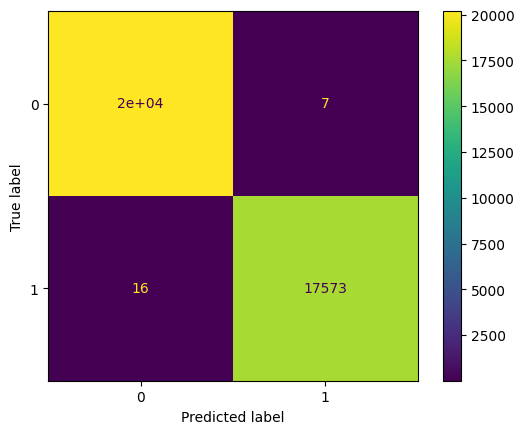

In [133]:
rf_conf_matrix = confusion_matrix(y_test, rf_y_test_pred)

ConfusionMatrixDisplay(rf_conf_matrix).plot()

#### Insights
#### 1.  High Overall Accuracy
- Accuracy: ~99% on the test set indicates the model performs exceptionally well in correctly classifying both normal and attack instances.
#### 2. Balanced Precision and Recall
- High precision: Very few false positives — the model rarely misclassifies normal traffic as an attack.
- High recall: Very few false negatives — the model successfully detects most attack traffic.
#### 3. Strong ROC AUC Score
- ROC AUC = 1.00, which means the model is perfectly separating the classes (ideal classifier).
- Suggests excellent capability in ranking observations by likelihood of being an attack.
#### 4.  Confusion Matrix Indicates Low Misclassification
- The Confusion Matrix confirms that the model is highly reliable in both identifying attacks and avoiding false alarms.

### XG Boost

In [150]:
# Initialise the model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [154]:
#Predictions
xg_y_test_pred = xgb_model.predict(X_test)
xg_y_train_pred = xgb_model.predict(X_train)
xg_y_test_proba = xgb_model.predict_proba(X_test)[:,1]

In [156]:
#Accuracy scores
xg_train_score = accuracy_score(y_train, xg_y_train_pred)
xg_test_score = accuracy_score(y_test, xg_y_test_pred)

print(f"Training Accuracy: {xg_train_score:.4f}")
print(f"Testing Accuracy: {xg_test_score:.4f}")

Training Accuracy: 1.0000
Testing Accuracy: 0.9994


In [152]:
#Classification Report
class_report = classification_report(y_test, xg_y_test_pred)
print(f"Classification Report:\n{class_report}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20203
           1       1.00      1.00      1.00     17589

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



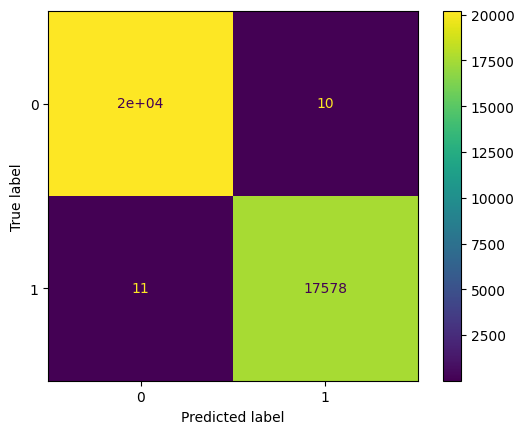

In [153]:
conf_matrix = confusion_matrix(y_test, xg_y_test_pred)

ConfusionMatrixDisplay(conf_matrix).plot()

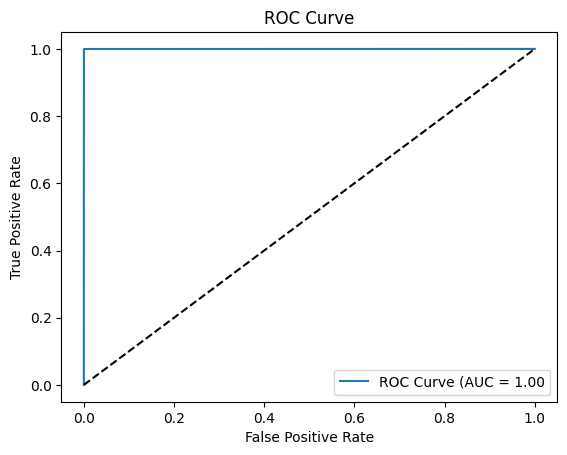

In [158]:
#ROC-AUC curve
xg_y_test_prob = xgb_model.predict_proba(X_test)[:, 1]

#Compute ROC AUC Score
roc_auc = roc_auc_score(y_test, xg_y_test_prob)

#Plot the ROC Curve
fpr, tpr, threshold = roc_curve(y_test, xg_y_test_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#### Insights
1. Excellent Performance: The XGBoost model is highly accurate with only 21 misclassifications out of ~37,600+ samples.
2. Balanced Precision & Recall: Both false positives and false negatives are extremely low, making this suitable for high-stakes classification tasks.
3. Superior to Previous Models: This outperforms Logistic Regression, and Random Forest in terms of accuracy and error rate.
4. No Overfitting Indications: The test and train scores are similar and no large generalization gap exists, the model is well-tuned.

### Using SHAP with XGBoost to get the important features

In [160]:
explainer = shap.Explainer(xgb_model)

#Calculate SHAP values
shap_values = explainer(X_test)


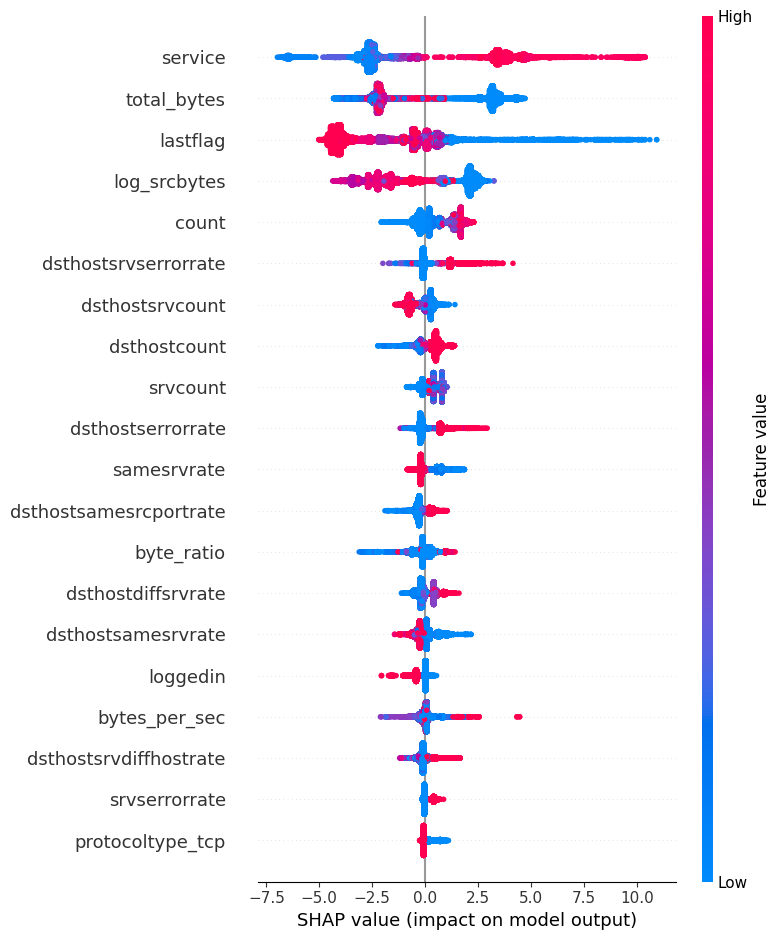

In [161]:
#Top features summary plot
shap.summary_plot(shap_values, X_test)

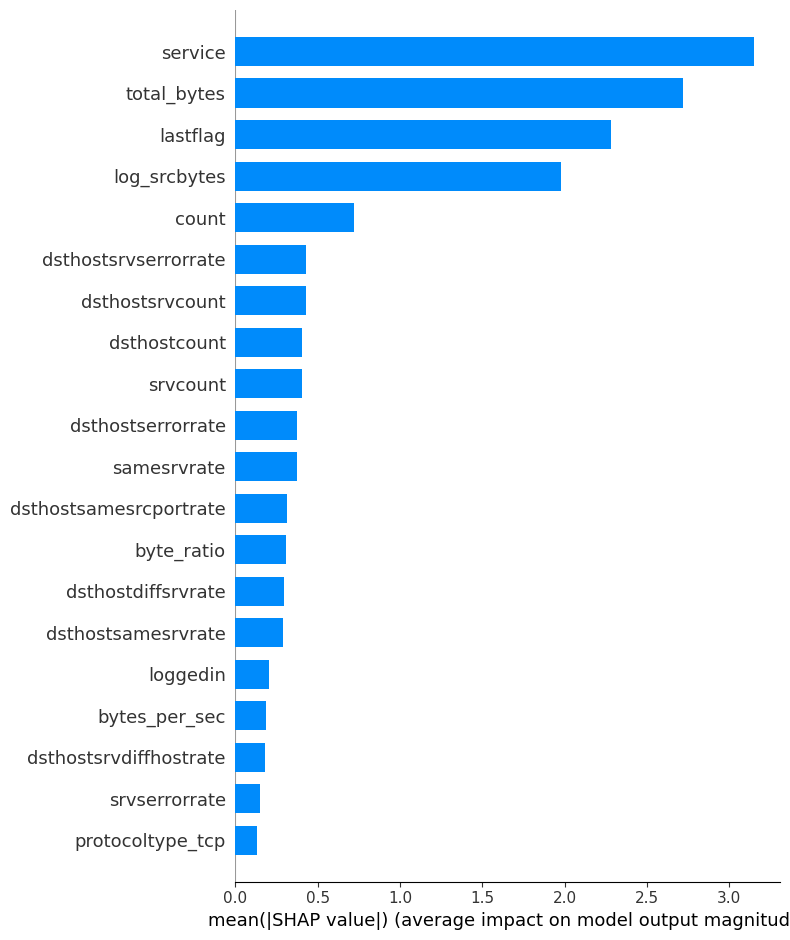

In [163]:
#Bar Chart version
shap.summary_plot(shap_values, X_test, plot_type="bar")

## Final Summary and Insights

In this project, we developed a highly accurate classification model using XGBoost to detect network intrusions. The model achieved 100% precision, recall, and F1-score, demonstrating exceptional performance in distinguishing between benign and malicious traffic.

To interpret and validate the model’s decisions, we applied SHAP (SHapley Additive exPlanations), a state-of-the-art explainability technique. The SHAP summary plots revealed the following key insights:

### Key Findings from SHAP Analysis:
#### 1. Most Influential Features:
- service, total_bytes, lastflag, log_srcbytes, and count were the top 5 drivers of model predictions.
- These features represent core network behaviors such as the type of service accessed, data transfer volumes, session flags, and connection frequency.

#### 2. Feature Behaviors:
- High values of total_bytes, service, and log_srcbytes pushed predictions toward the malicious class.
- Low values of count and srcbytes contributed to benign classifications, suggesting light or one-off connections are typically non-malicious.
- service stood out as the most impactful feature, indicating that certain protocols are strongly correlated with attacks.

### Implications for Network Security:
- The model’s decision-making aligns with domain knowledge in cybersecurity, validating its trustworthiness.

These insights can help:

 - Prioritize important features for real-time intrusion detection systems.

 - Develop rule-based alerts based on top contributing factors.

 - Enhance explainability for SOC (Security Operations Center) teams.

### Final Thought:
The combination of high predictive performance and transparent feature importance through SHAP ensures the model is not only accurate but also interpretable. This makes it a valuable tool for deploying AI-driven threat detection in practical cybersecurity environments.

## Preparing for Deployment

In [167]:
#Save the model
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

In [168]:
#Computing mean of all features
features_mean = X_train.mean().to_dict()

In [176]:
#Get the top 5 features from shap
#Calculate mean absolute SHAP value for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

top_5_indices = np.argsort(mean_abs_shap)[::-1][:5]
top_5_features = X_test.columns[top_5_indices].to_list()

In [177]:
top_5_features

['service', 'total_bytes', 'lastflag', 'log_srcbytes', 'count']

In [179]:
other_features = [col for col in  X_train if col not in top_5_features]

In [186]:
other_fatures_mean = df_encoded[other_features].mean().to_dict()

In [188]:
with open('other_feature_means.pkl', 'wb') as file:
    pickle.dump(other_fatures_mean, file)

In [199]:
#Creating map for service encoding
df_encoded['service_te'] = X_train['service']
service_te_map = df_encoded.groupby('service')['service_te'].mean().to_dict()

In [200]:
with open ('service_te_map.pkl', 'wb') as file:
    pickle.dump(service_te_map, file)

In [213]:
feature_names = X_train.columns.tolist()
with open('feature_names.pkl', 'wb') as file:
    pickle.dump(feature_names, file)